<a href="https://colab.research.google.com/github/jpdosher/Projetos-EDA/blob/main/cub_brasil_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='DarkBlue'>**Índice CUB Brasil** 

O objetivo deste notebook é a princípio fazer uma boa análise dos dados e testar/aprender um pouco.

O Custo Unitário Básico de Construção (CUB) é um indicador de custos no setor da construção calculado e divulgado pelos Sinduscons estatuais e regido pela Lei Federal 4.591/64.
O CUB Brasil é uma média ponderada dos indicadores de alguns dos principais estados da federação. Este tópico contém informações sobre a evolução do CUB Brasil e dos estados que o compõem.

**Fontes:**
> CBIC-Câmara Brasileira da Indústria da Construção - "http://www.cbicdados.com.br/menu/custo-da-construcao/cub-medio-brasil-custo-unitario-basico-de-construcao-por-m2"
>
>SINAPI: https://www.caixa.gov.br/poder-publico/modernizacao-gestao/sinapi/Paginas/default.aspx
>
>Câmara brasileira da industria da Construção: http://www.cub.org.br/cub-m2-brasil



#<font color='DarkBlue'>Importando dados, pré-visualização, pré-análise e primeiras transformações

In [1]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
%pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import data_table
data_table.enable_dataframe_formatter()   #use .disable para desabilitar (tabelas dinâmicas)
# #data_table.disable_dataframe_formatter()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.4 MB 4.1 MB/s 
     |████████████████████████████████| 9.8 MB 22.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
  #leitura do arquivo do Google Drive
df = pd.read_csv('/content/drive/MyDrive/Data Science/Dataset/df_cub_index.csv') #parse_dates=['year','month']

---

## Pré-visualizando os dados carregados

Visão geral da tabela:

In [3]:
df.shape

(3548, 9)

In [4]:
#primeiras linhas
df.head()

,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
0,2007,2,AL,611.28,325.22,242.30,26.49,17.27,2.630
1,2007,3,AL,606.19,334.63,242.30,22.75,6.51,2.625
2,2007,4,AL,613.36,341.80,242.30,22.75,6.51,2.630
3,2007,5,AL,619.35,336.79,254.65,21.40,6.51,2.635
4,2007,6,AL,617.76,334.43,254.65,22.28,6.40,2.660


In [5]:
#últimas linhas
df.tail()

,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
3543,2021,3,SC,2171.33,819.38,1300.81,47.63,3.52,6.35
3544,2021,4,SC,2203.29,848.55,1303.66,47.50,3.58,6.78
3545,2021,5,SC,2253.79,879.74,1322.23,48.22,3.61,6.86
3546,2021,6,SC,2307.92,896.13,1358.30,49.74,3.75,6.87
3547,2021,7,SC,2329.85,909.25,1366.99,49.84,3.78,7.12


---
Descrição das colunas, segundo o  do provedor do DataSet:




* state: unidade federativa do brasil

* globalvalue: valor total 

* cmvalue: valor componentes materiais

* cmovalue: valor componentes mão de obra 

* cdavalue: valor componentes despesa administrativa

* ce_value: valor componentes equipamento

* (globalvalue = cmvalue + cmovalue + cdavalue + ce_value )

> **Todas as colunas de valor utilizam a unidade R$/m²

* ca50_value: evolução do valor do aço ca50 10mm no período (R$/Kg)

---

In [6]:
#Quantidade de registros por ano
dados_por_ano = df.groupby('year').year.count()
dados_por_ano

year
2007    220
2008    240
2009    240
2010    240
2011    240
2012    240
2013    240
2014    240
2015    241
2016    252
2017    252
2018    252
2019    252
2020    259
2021    140
Name: year, dtype: int64

## Avaliando a qualidade de dados do df:




1.   Checar valores ausentes









In [7]:
df.isnull().sum()  

year            0
month           0
state           0
global_value    0
cm_value        0
cmo_value       0
cda_value       0
ce_value        0
ca50_value      0
dtype: int64

In [8]:
#também  poderia ser utilizado
print("Valores nulos = " + str(df.isna().sum().any()))

Valores nulos = False


> Temos **"0"** valores ausentes

2.   Existem linhas duplicadas?

In [9]:
df.duplicated().sum().any()

False

**"Falso"** para linhas duplicadas


3. Tipos de dados das colunas


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          3548 non-null   int64  
 1   month         3548 non-null   int64  
 2   state         3548 non-null   object 
 3   global_value  3548 non-null   float64
 4   cm_value      3548 non-null   float64
 5   cmo_value     3548 non-null   float64
 6   cda_value     3548 non-null   float64
 7   ce_value      3548 non-null   float64
 8   ca50_value    3548 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 249.6+ KB


Ano e mês estão com int64, mas para avaliação/manipulaçao de dados o ideal é trata-los como tipo "data".Para este caso, concatenarei as colunas ['year'] e ['month'] em uma coluna chamada ['periodo'] no formato string para posteriormente converte-la no formato datetime do pandas



In [11]:
df["periodo"] = df["year"].astype(str) + '-' + df["month"].astype(str)

In [12]:
df["periodo"] = pd.to_datetime( df["periodo"] )

In [13]:
#converte o formato "%Y/%m/%d" que tinha valores de dia nulo para formato "%Y/%m"
df["periodo"] = pd.to_datetime( df["periodo"],format='%Y00%m').apply(lambda x: x.strftime('%Y-%m') )

In [14]:
df.info()   #types após conversão

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          3548 non-null   int64  
 1   month         3548 non-null   int64  
 2   state         3548 non-null   object 
 3   global_value  3548 non-null   float64
 4   cm_value      3548 non-null   float64
 5   cmo_value     3548 non-null   float64
 6   cda_value     3548 non-null   float64
 7   ce_value      3548 non-null   float64
 8   ca50_value    3548 non-null   float64
 9   periodo       3548 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 277.3+ KB


In [15]:
#alterar posição da coluna 'periodo'
cols = list(df.columns.values)
cols

['year',
 'month',
 'state',
 'global_value',
 'cm_value',
 'cmo_value',
 'cda_value',
 'ce_value',
 'ca50_value',
 'periodo']

In [16]:
# #setando a coluna 'periodo' como índice
# df.set_index('periodo', inplace = True)

Nesta estapa, está finalizado a conversão das colunas 'year' e 'month' para tipo datetime.

# Avaliando estatísicas
Antes de prosseguir para as perguntas de negócio irei avaliar os dados com perspectiva estatística. Como fundamentado anteriormente os dados são dispostos ao longo do tempo, são uma série temporal, avaliações estatísticas como estimações de localizações e distribuições não são válidas para avaliar a série como um inteiro.

## Decompondo e comparando variáveis ao longo do tempo

Para a análise, irei agregar os valores mensais de todos os estados pela média

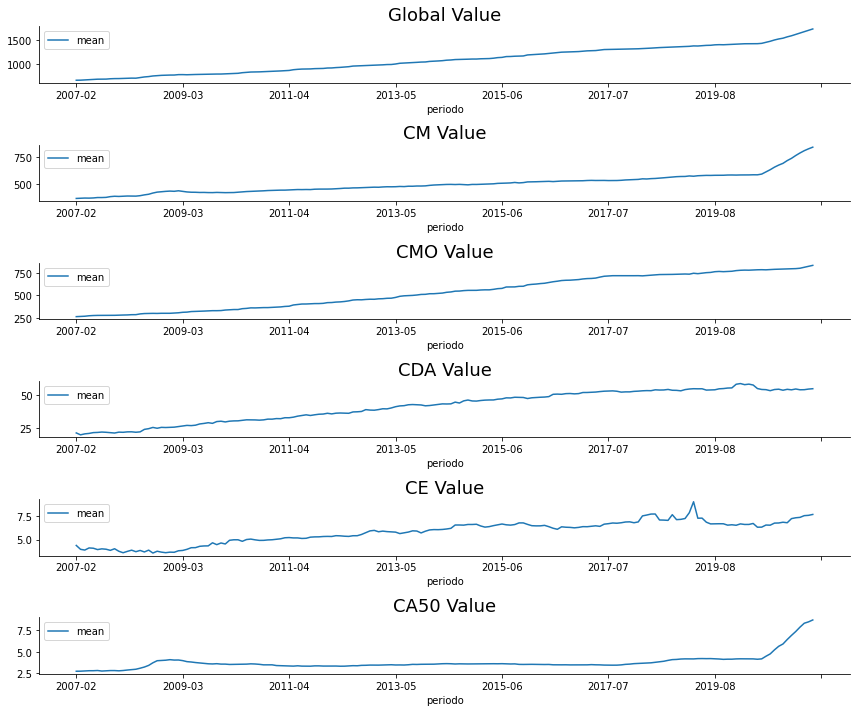

In [17]:
#Comparando as variáveis ao longo do tempo
fig, axarr = plt.subplots(6, 1, figsize=(12, 10))
df.groupby(['periodo']).global_value.agg([np.mean]).plot(
    ax = axarr[0]
)
axarr[0].set_title("Global Value", fontsize=18)

df.groupby(['periodo']).cm_value.agg([np.mean]).plot(
    ax = axarr[1], 
)
axarr[1].set_title("CM Value", fontsize=18,)


df.groupby(['periodo']).cmo_value.agg([np.mean]).plot(
    ax = axarr[2]
)
axarr[2].set_title("CMO Value", fontsize=18)

df.groupby(['periodo']).cda_value.agg([np.mean]).plot(
    ax = axarr[3]
)
axarr[3].set_title("CDA Value", fontsize=18)

df.groupby(['periodo']).ce_value.agg([np.mean]).plot(
    ax = axarr[4],
)
axarr[4].set_title("CE Value", fontsize=18)

df.groupby(['periodo']).ca50_value.agg([np.mean]).plot(
    ax = axarr[5]
)
axarr[5].set_title("CA50 Value", fontsize=18)

plt.subplots_adjust(hspace=2.5)
plt.tight_layout()
sns.despine()

Claramente é observado que o preço de materiais (incluíndo aço) teve o maior peso na alta iniciada no segundo semestre de 2020, pelo motivo da oferta reduzida de materiais na indústria -efeito colateral do COVID-19. Correlacionando os valores temos uma melhor idéia do impacto de cada componente do índice:

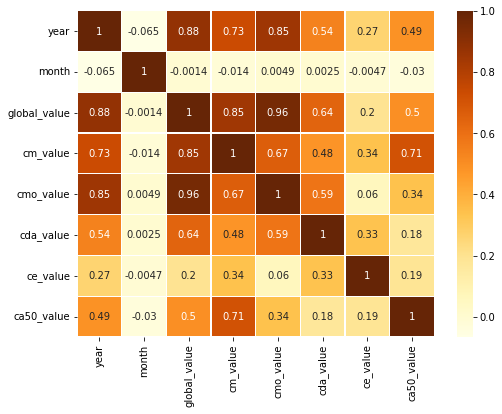

In [18]:
#correlação ou covariância
corr_df = df.corr(method = 'pearson') #Utilizar método de pearson quano não houver presença de outliers
corr_df
#plotando com seaborn
plt.figure(figsize=(8, 6))


cmap = "YlOrBr"
sns.heatmap(corr_df, annot=True,  linewidths = .3, cmap = cmap)

plt.show()

## Avaliando série temporal

Agora avaliarei a série temporal para identificar ciclos, sazonalidades e/ou tendências.

In [19]:
#Criando uma série temporal com as médias mensais
ts = df.groupby(['periodo']).global_value.agg([np.mean])

In [20]:
ts.head()

,mean
periodo,
2007-02,653.7870
2007-03,655.2360
2007-04,660.7655
2007-05,665.7935
2007-06,670.9335


In [21]:
#visualizando tipos dos dados das colunas
ts.dtypes

mean    float64
dtype: object

In [22]:
#visualizando tipo de dados do índice
ts.index

Index(['2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07',
       '2007-08', '2007-09', '2007-10', '2007-11',
       ...
       '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
       '2021-04', '2021-05', '2021-06', '2021-07'],
      dtype='object', name='periodo', length=174)

In [23]:
#índice está como tipo "object", convertendo o índice
ts.index = pd.to_datetime(ts.index)

In [24]:
#visualização do resultado da conversão do índice
ts.index

DatetimeIndex(['2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01',
               ...
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01'],
              dtype='datetime64[ns]', name='periodo', length=174, freq=None)

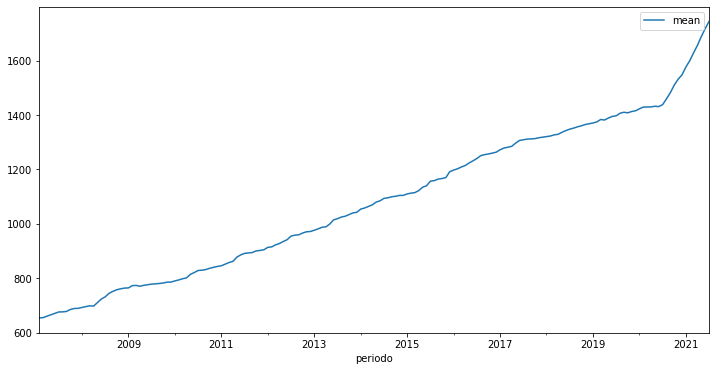

In [25]:
#plotando
ts.plot(figsize = (12,6))

O teste Dickey-fuller confirma se a série temporal é estacionária

In [26]:
def adf_test(dataset):
  result = adfuller(dataset, autolag='AIC')
  print('ADF Statistic: %f' % result[0])

  print('p-value: %f' % result[1])

  print('Critical Values:')

  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Ho - Time Series is Stationary")
  else:
      print ("Failed to Reject Ho - Time Series is Non-Stationary")
        

In [27]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()
    plt.figure(figsize=(12,7))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Média móvel')
    std = plt.plot(rolstd, color='green', label = 'Desvio padrão móvel')
    plt.xlabel("Data")
    plt.ylabel("Média Global Value")
    plt.title('Média móvel e desvio padrão')
    plt.legend()
    plt.show()

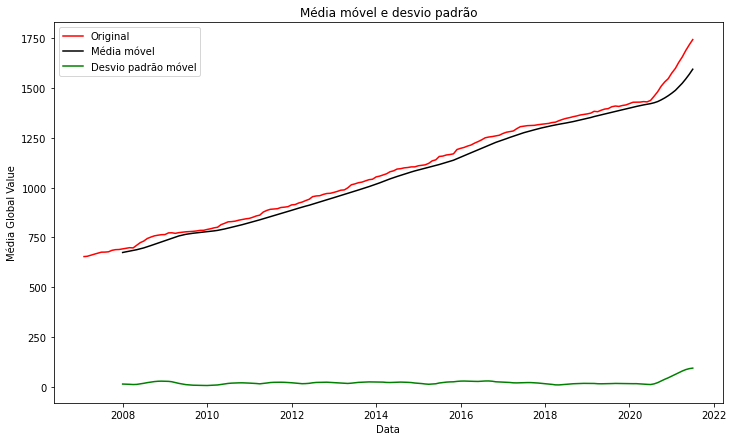

In [28]:
check_mean_std(ts['mean'])

In [29]:
#Aplicando teste ad-fuller
adf_test(ts['mean'])

ADF Statistic: 1.831930
p-value: 0.998410
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576
Failed to Reject Ho - Time Series is Non-Stationary




  Observando o gráfico, a média não é constante (linha preta)define-se que a série não é estacionária.


  O segundo é a variação constante, parece constante. (sim estacionário). 


  O terceiro é que, se a estatística do teste for menor que o valor crítico, podemos dizer que a série temporal é estacionária (não é o nosso caso). Vamos olhar:


      test statistic = 1.83 
      critical values = {'1%': -3.469, 
                        '5%': -2.879,
                        '10%': -2.576}. 
      
  Reafirmando, está confirmado que nossa série temporal não é estacionária.
  Para continuar a análise, a série temporal devem ser transformada em estacionária.



<Figure size 432x288 with 0 Axes>

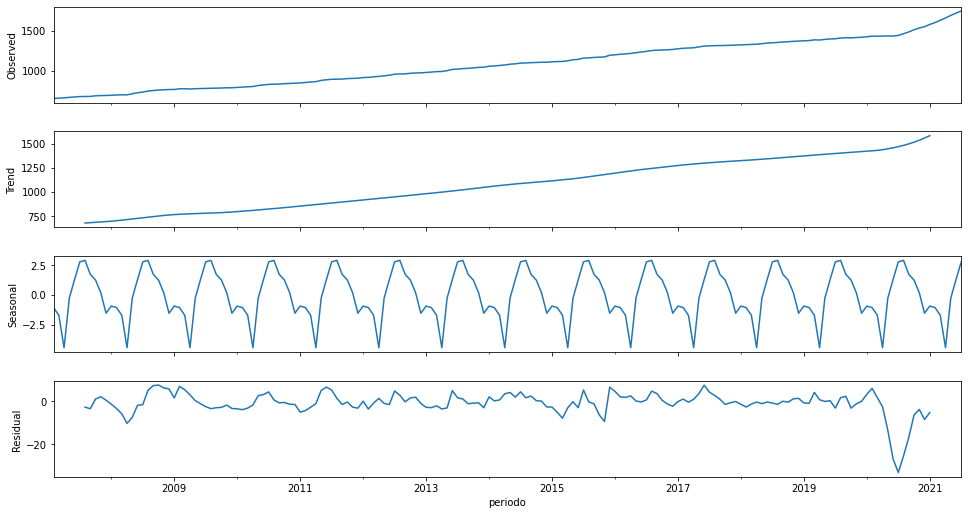

In [30]:
#método por decomposição
from statsmodels.tsa.seasonal import seasonal_decompose
# Decomposing Time series
decomposition = seasonal_decompose(ts['mean'], freq=12)  
def decomposition_plot():
  fig = plt.figure()  
  fig = decomposition.plot()  
  fig.set_size_inches(15, 8)
decomposition_plot()

In [31]:
#método por diferenciação
n_diff_dataset = pd.DataFrame(data=np.diff(np.array(ts['mean'])))
n_diff_dataset.columns = ['mean']

In [32]:
#teste após 1ª transformação
adf_test(n_diff_dataset['mean'])

ADF Statistic: -1.873730
p-value: 0.344519
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576
Failed to Reject Ho - Time Series is Non-Stationary


In [33]:
#2ª diferenciação
n_diff_dataset_2 = pd.DataFrame(data=np.diff(n_diff_dataset['mean']))
n_diff_dataset_2.columns = ['mean']

In [34]:
#teste após 2ª transformação
adf_test(n_diff_dataset_2['mean'])

ADF Statistic: -9.312754
p-value: 0.000000
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
Reject Ho - Time Series is Stationary


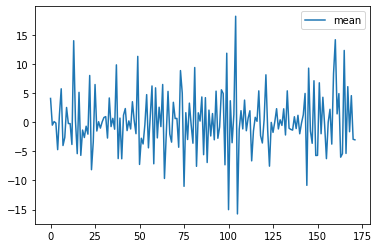

In [35]:
n_diff_dataset_2.plot()

O teste de estacionariedade e a transformação em série estacionária neste projeto serão apenas para propósitos de aprendizado, explicarei mais adiante os motivos.

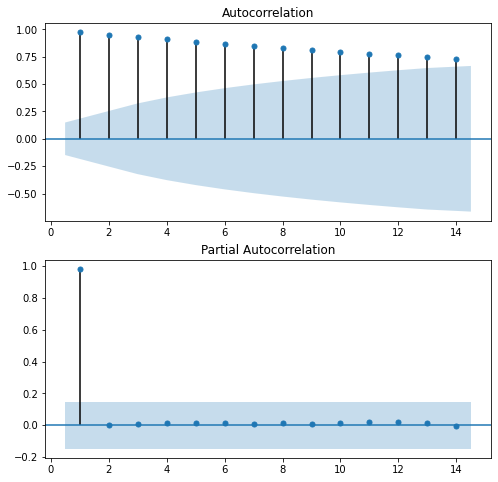

In [36]:
#ACF e PACF

fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(ts,lags=14, zero=False, ax=ax1)
plot_pacf(ts,lags=14, zero=False, ax=ax2)
plt.show()


A análise de autocorrelação ajuda na detecção de padrões ocultos e sazonalidade e na verificação de aleatoriedade. É especialmente importante quando você pretende usar um modelo ARIMA para previsão porque a análise de autocorrelação ajuda a identificar os parâmetros AR e MA para o modelo ARIMA.

fonte: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf/notebook 

## Forecast com Arima

Como o assunto séries temporais é praticamente um curso a parte, por hora vou me ater ao modelo ARIMA, onde o "I" corresponde ao método/procedimento implícito de diferenciação que transforma a série temporal em uma série estacionária.

### Aplicando o modelo

In [37]:
# Auto ARIMA 
fit_arima = auto_arima(ts, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=1112.308, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1041.457, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=1054.183, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=1086.109, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=1037.747, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=1098.132, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=1023.600, Time=0.53 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=1028.644, Time=0.28 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=2.60 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=999.905, Time=1.38 sec
 ARIMA(2,1,0)(0,1,1)[6]             : AIC=inf, Time=0.75 sec
 ARIMA(2,1,0)(1,1,2)[6]             : AIC=inf, Time=2.46 se

In [38]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

model = SARIMAX(ts,order=(3,1,0),  seasonal_order=(1, 1, 2, 6))
resultado_sarimax = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  periods=len(index) + 1,
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


In [39]:
# resultados do modelo SARIMAX(2,1,2)
result_sum = resultado_sarimax.summary()
print(result_sum)

                                 Statespace Model Results                                
Dep. Variable:                              mean   No. Observations:                  174
Model:             SARIMAX(3, 1, 0)x(1, 1, 2, 6)   Log Likelihood                -488.279
Date:                           Sun, 17 Apr 2022   AIC                            990.558
Time:                                   08:55:22   BIC                           1012.384
Sample:                               02-01-2007   HQIC                           999.417
                                    - 07-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4511      0.059      7.588      0.000       0.335       0.568
ar.L2          0.2308      0.088      2.635

In [40]:
# Vamos realizar um "backtesting" com predições de valores dos #12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [41]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(1431.6200420593432, 1448.6173708070323)

In [42]:
predicao_media[0]

1440.1187064331878

In [43]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(ts.index)

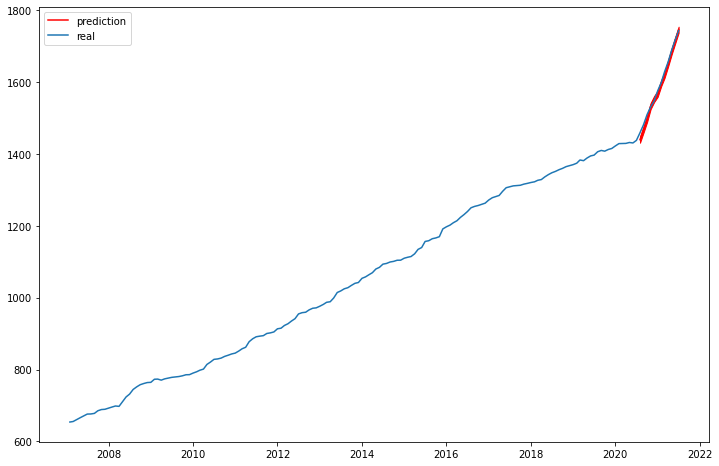

In [44]:
plt.figure(figsize=(12,8))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, ts.values, label='real')
plt.legend()
plt.show()

Erro médio quadrádico

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(ts[-12:].values,predicao_media.values))
print(rmse_sarima)

8.720221561082402


### Forecast

In [46]:
# Forecast pra 12 períodos
forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [47]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(1895.3843073481382, 2090.065677226773)

In [48]:
forecast_medio[10]

1992.7249922874555

In [49]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

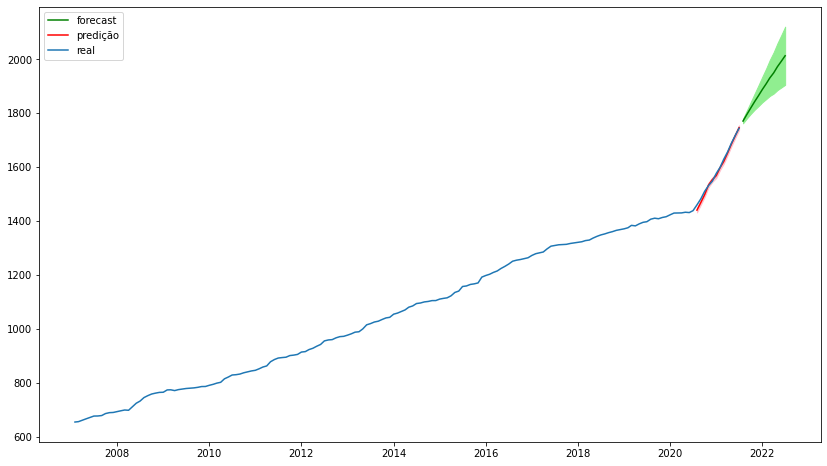

In [50]:
def plot_forecast():
  dates=np.asarray(ts.index)
  plt.figure(figsize=(14,8))
  plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
  plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

  plt.plot(datas_previsao,predicao_media.values,color='red',label='predição')
  plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

  plt.plot(dates,ts.values, label='real')
  plt.legend(loc='upper left')
  plt.show()
plot_forecast()

O modelo aplicado se mostrou de certa forma conservador, manteve a tendência porém com um certo amortecimento. 

In [51]:
df_forecast = pd.Series(forecast_medio, index = datas_forecast)
df_forecast

2021-08-01    1770.633829
2021-09-01    1795.457262
2021-10-01    1818.869331
2021-11-01    1842.525733
2021-12-01    1864.221887
2022-01-01    1887.588046
2022-02-01    1909.163864
2022-03-01    1930.352577
2022-04-01    1949.295200
2022-05-01    1972.443736
2022-06-01    1992.724992
2022-07-01    2012.965809
dtype: float64

#<font color='DarkBlue'>Perguntas de negócio

## 1.Quais são os 3 estados com o maior custo global atual? E quais são os com os menores valores?

In [52]:
#filtrando os dados de 2020/2021, verificando o último mês apontado
ano_20_21 = df.loc[df.periodo > "2021-06"]

In [53]:
#visualizando o df
filtro = ano_20_21.sort_values(by='global_value',ascending=False)
filtro.head(3)

,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value,periodo
3547,2021,7,SC,2329.85,909.25,1366.99,49.84,3.78,7.12,2021-07
3131,2021,7,RS,2089.06,1144.99,858.51,70.61,14.95,11.24,2021-07
1043,2021,7,ES,2058.67,1026.25,944.82,84.24,3.37,7.05,2021-07


In [54]:
filtro.tail(3)

,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value,periodo
695,2021,7,CE,1405.52,629.01,735.44,37.30,3.77,7.26,2021-07
1391,2021,7,PB,1372.93,627.83,708.48,32.77,3.85,8.62,2021-07
3305,2021,7,SE,1312.45,652.68,619.17,36.08,4.53,6.88,2021-07


Respectivamente; Santa Catarina, Rio Grande de Sul e Espírito Santo têm os três maiores valores de "global_value".
Quanto aos menores valores, temos Ceará, Paraíba e por último, Sergibe

## 2. A tendência de aumento/queda nos preços manteve um padrão?

Esta secção tem o intuíto de apontar as nuances das taxas de aumento dos valores aplicados. Aqui reutilizando a decomposição da média de global_value para demonstrar a tendência.

<Figure size 432x288 with 0 Axes>

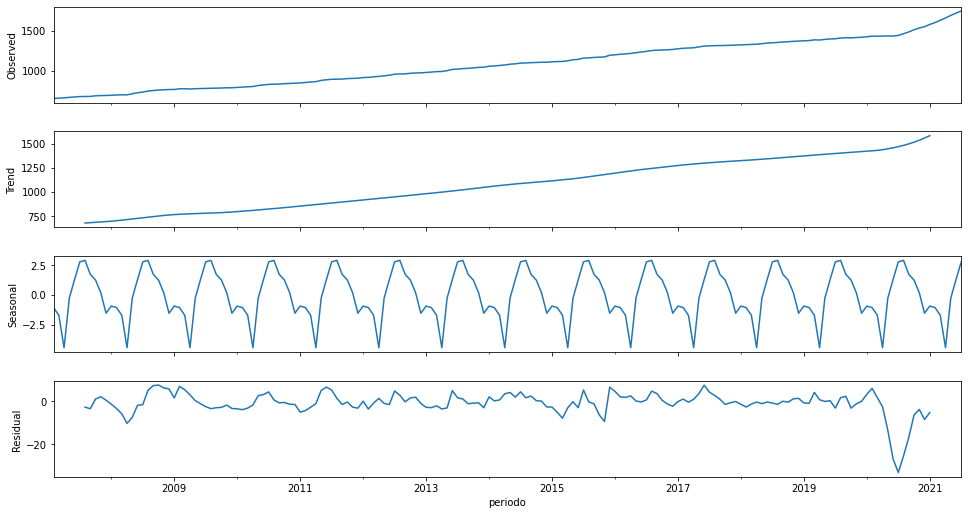

In [55]:
decomposition_plot()

Nota-se que já existia uma tendência de alta linear juntamente com uma sazonalidade contínua. Para efeitos de comparação, comparei a média do período observado (02/2007 à 07/2021) com o índice IGP-M no mesmo período:

In [56]:
#Média de global_value para a primeira observação
ts.loc['2007-02-01']

mean    653.787
Name: 2007-02-01 00:00:00, dtype: float64

In [57]:
#Média de global_value para a última observação
ts.loc['2021-07-01']

mean    1744.024
Name: 2021-07-01 00:00:00, dtype: float64

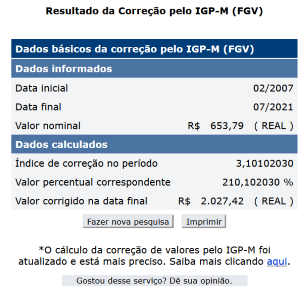


Fonte: https://www3.bcb.gov.br/CALCIDADAO/publico/corrigirPorIndice.do?method=corrigirPorIndice

Acesso público 15/04/2022 - 19:31


Nota-se que a média observada não acompanhou o índice no mesmo período, entretanto é necessáiro maiores observações e ponderações quanto ao peso do custo de construção no IGP-M.

## 3. Previsão para os próximos 3 meses

Revendo a plotagem das predições

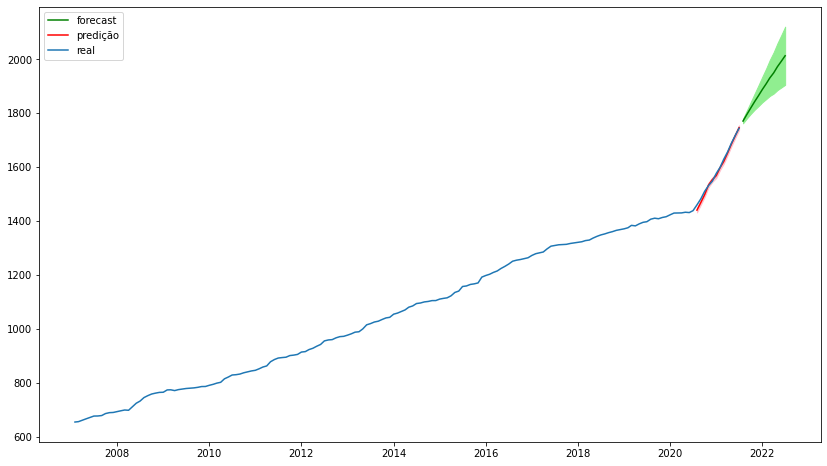

In [58]:
plot_forecast()

E os valores mensais das predições.

In [59]:
df_forecast

2021-08-01    1770.633829
2021-09-01    1795.457262
2021-10-01    1818.869331
2021-11-01    1842.525733
2021-12-01    1864.221887
2022-01-01    1887.588046
2022-02-01    1909.163864
2022-03-01    1930.352577
2022-04-01    1949.295200
2022-05-01    1972.443736
2022-06-01    1992.724992
2022-07-01    2012.965809
dtype: float64

O modelo seguiu a tendência de aumento, porém com um certo amortecimento

# <font color = 'Red'>**Considerações e anotações.**

A princípio 
Deixei as anotações de projeto em https://jpdosher.notion.site/ndice-CUB-de-materiais-de-contru-o-584a08f7da15481fa7546fcd6878cfb6